# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I used the skills that I learned in the second lecture to identify lane lines on the road.

I developed a pipeline on a series of individual images, and later applied the result to a video stream (really just a series of images).

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

# Global Variables
# Region-of-interest ofsets
top_x_offset = 0.45
top_y_offset = 0.60
bottom_x_offset = 0.07

# Stores the left and right lines from an image.
# Notice, need to clear before using it on new set of images (video).
right_lines = []
left_lines = []

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lines2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.suptitle(title)
    plt.show()
    

# Improvement of draw_lines function
def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    threshold =  0.5
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Step 1. Get line slope to determine if its left or right side
            len = math.hypot(x2 - x1, y2 - y1)
            
            # Advoid divided by 0 exception
            if x1 == x2:
                continue
                
            slope = ((y2-y1)/(x2-x1))
            
            # only accept slopes >= threshold
            if abs(slope) < threshold:
                continue
            
            if (slope >= threshold ): # Then its Right side
                right_lines.append(line[0])
            elif (slope < -threshold ): # Then its Left side
                left_lines.append(line[0])
                
            # y = m*x + b
            right_m = right_b = 1 
            
            # Get right lines  sets of x's and y's, for calculating Extrapolation based 
            # on least-squares curve-fitting calculations
            # https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/06LeastSquares/extrapolation/complete.html
            right_lines_x = [x1 for x1, y1, x2, y2 in right_lines] + [x2 for x1, y1, x2, y2 in right_lines]
            right_lines_y = [y1 for x1, y1, x2, y2 in right_lines] + [y2 for x1, y1, x2, y2 in right_lines]

            if right_lines_x:
                right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b

            left_m = left_b = 1
            # collect left lines x and y sets for least-squares curve-fitting calculating
            left_lines_x = [x1 for x1, y1, x2, y2 in left_lines] + [x2 for x1, y1, x2, y2 in left_lines]
            left_lines_y = [y1 for x1, y1, x2, y2 in left_lines] + [y2 for x1, y1, x2, y2 in left_lines]

            if left_lines_x:
                left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1) 
            
            y_size = img.shape[0]
            
            y1 = y_size
            y2 = int(y_size*top_y_offset)

            right_x1 = int((y1-right_b)/right_m)
            right_x2 = int((y2-right_b)/right_m)

            left_x1 = int((y1-left_b)/left_m)
            left_x2 = int((y2-left_b)/left_m)

            if right_lines_x:
                cv2.line(img, (right_x1, y1), (right_x2, y2), [255,0,0], 5)
            if left_lines_x:
                cv2.line(img, (left_x1, y1), (left_x2, y2), [255,0,0], 5)
        
                
                

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [4]:
def process_image(image, display_images=False):
        
    # Step 1. Convert the image to grayscale.
    gray_image = grayscale(image)
    
    # Step 2. Blur using Gaussian smoothing / blurring
    # kernel_size = 5
    blurred_image = gaussian_blur(gray_image, 5)
    
    # Step 3. Use Canny Edge Detection to get a image of edges
    # low_threshold = 50
    # high_threshold = 150)
    edged_image = canny(blurred_image, 50, 150)
    
    
    # Step 4. Mask with a trapozoid the area of interest
    y_size = image.shape[0]
    x_size = image.shape[1]
    
    tx = int(x_size * top_x_offset)
    bx = int(x_size * bottom_x_offset)
    ty = int(y_size * top_y_offset)
    
    vertices = np.array( [[
                (bx, y_size),# Bottom Left
                (tx, ty),   # Top Left
                (x_size - tx, ty),   # Top Right
                (x_size - bx, y_size)    # Bottom Right
            ]], dtype=np.int32 )

    roi_img = region_of_interest(edged_image, vertices)

    # Step 5. Run Hough Transformation on masked edge detected image
    houghed_image = hough_lines(roi_img, 1, np.pi/180, 40, 30, 200)

    # Step 6. # Draw the lines on the original image
    final_image = weighted_img(houghed_image, image)
    
    if display_images:
        display_image(image, "Original Image")
        display_image(gray_image, "Grayscale Image")
        display_image(blurred_image, "Gaussian Blured Image")
        display_image(edged_image, "Canny Edge Detectioned Image")
        display_image(roi_img, "Region of Interest Mapped Image")
        display_image(houghed_image, "Hough Transformed Image")
        display_image(final_image, "Final image")

    return final_image

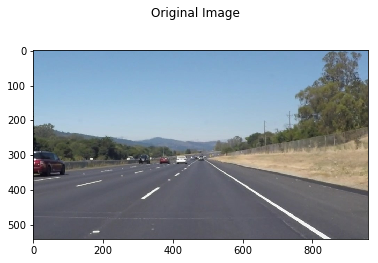

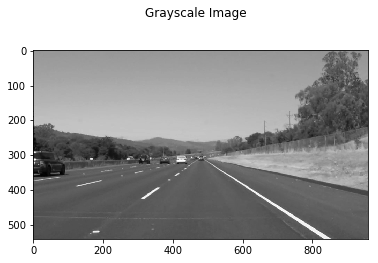

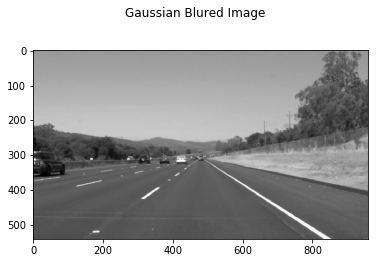

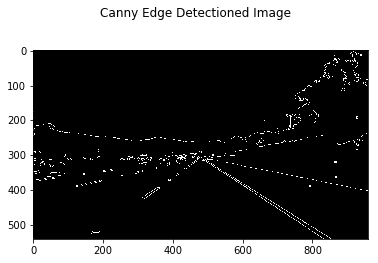

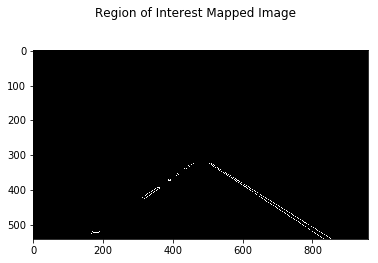

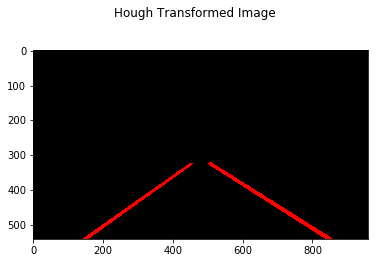

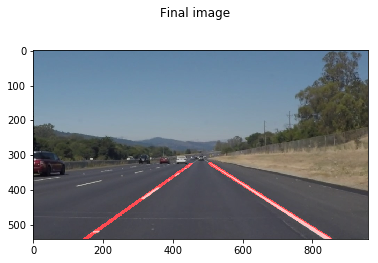

In [5]:
final_image = process_image(mpimg.imread('test_images/solidWhiteRight.jpg'), True)

In [6]:
in_directory = "test_images"
# Create a corresponding output directory
out_directory = in_directory + "_out"
if not os.path.exists(out_directory):
    os.makedirs(out_directory)

# Get all images in input directory and store their names
imageNames = os.listdir(in_directory + "/")
for imageName in imageNames:
    image = mpimg.imread(in_directory + "/" + imageName)
    # Apply my Lane Finding Image Processing Algorithm on each image
    resultImage = process_image(image)
    # Save the result in the output directory
    mpimg.imsave(out_directory + "/" + imageName, resultImage)

## Test on Videos

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [8]:
right_lines.clear()
left_lines.clear()
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:08<00:00, 17.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.68 s


In [9]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/JkmnV8MGrqY?list=PLDzoIbwAYMT8loNc93MtJupWa40aKX4Sj" frameborder="0" allowfullscreen></iframe>')

In [10]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0VcgueMyfdw?list=PLDzoIbwAYMT8loNc93MtJupWa40aKX4Sj" frameborder="0" allowfullscreen></iframe>')

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
right_lines.clear()
left_lines.clear()
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [01:11<00:00,  5.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 11s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

I modified my pipeline so it works with this video and submited it along with the rest of my project!

In [14]:
right_lines.clear()
left_lines.clear()
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00,  8.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 15.4 s


In [15]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/g1BLQDu2z60?list=PLDzoIbwAYMT8loNc93MtJupWa40aKX4Sj" frameborder="0" allowfullscreen></iframe>')

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))